# Chapter 7 - Interobserver variability

## Gleason 2019 experiments

Reproducing the interobserver variability results.

In [1]:
from metrics.gleason import compute_scores, get_kappas
import numpy as np

maps_experts = [f'Expert {i}' for i in range(1,7)]
maps_STAPLE = ['STAPLE'] + [f'LoO_STAPLE_{i}' for i in range(1,7)]
maps_MV = ['Majority Voting'] + [f'LoO_MV_{i}' for i in range(1,7)]
maps_WV = ['Weighted Voting'] + [f'LoO_WV_{i}' for i in range(1,7)]
maps_labels = maps_experts + maps_STAPLE + maps_MV + maps_WV

# 0 = background, 1 = benign, 2 = never used, 3, 4, 5 = grades
px_per_grades = np.load("./data/gleason2019_px_per_grades.npy") # images x map x grade
has_annotations = np.load("./data/gleason2019_has_annotations.npy")

G_SP, E_SP, G_ISUP, E_ISUP = compute_scores(px_per_grades)

Annotations per expert (after removing annotation maps with clear mistakes):

In [2]:
print(has_annotations[:, :6].sum(axis=0))

[237.  20. 186. 235. 244.  64.]


In [3]:
# Compute kappas_U and kappas_Q
kappas_G_SP_U, all_kappas_n = get_kappas(G_SP, has_annotations, labels=range(11))
kappas_G_ISUP_U, _ = get_kappas(G_ISUP, has_annotations, labels=range(11))
kappas_E_SP_U, _ = get_kappas(E_SP, has_annotations, labels=range(1, 6))
kappas_E_ISUP_U, _ = get_kappas(E_ISUP, has_annotations, labels=range(1, 6))

kappas_G_SP_Q, _ = get_kappas(G_SP, has_annotations, labels=range(11), w="quadratic")
kappas_G_ISUP_Q, _ = get_kappas(G_ISUP, has_annotations, labels=range(11), w="quadratic")
kappas_E_SP_Q, _ = get_kappas(E_SP, has_annotations, labels=range(1, 6), w="quadratic")
kappas_E_ISUP_Q, _ = get_kappas(E_ISUP, has_annotations, labels=range(1, 6), w="quadratic")

### Expert vs Expert

In [4]:
scorings = {
    'kappaU - G-SP': kappas_G_SP_U,
    'kappaU - G-ISUP': kappas_G_ISUP_U,
    'kappaU - E-SP': kappas_E_SP_U,
    'kappaU - E-ISUP': kappas_E_ISUP_U,
    'kappaQ - G-SP': kappas_G_SP_Q,
    'kappaQ - G-ISUP': kappas_G_ISUP_Q,
    'kappaQ - E-SP': kappas_E_SP_Q,
    'kappaQ - E-ISUP': kappas_E_ISUP_Q
}

print("Expert v Expert:")
for label, all_kappas in scorings.items():
    print(label)
    kappas = all_kappas[:6,:6]
    kappas_n = all_kappas_n[:6,:6]
    kappas2 = kappas*(1-np.eye(kappas.shape[0]))
    print("Expert\tAvg\tMin\tMax")
    for i in range(kappas.shape[0]):
        weighted_avg = (kappas2[i,:]*kappas_n[i,:]).sum()/kappas_n[i, :].sum()
        print("%d\t%.2f\t%.2f\t%.2f"%(i+1, weighted_avg, kappas[i,:].min(), kappas2[i,:].max()))
    print("Avg: %.2f"%((kappas*kappas_n).sum()/kappas_n.sum()))

Expert v Expert:
kappaU - G-SP
Expert	Avg	Min	Max
1	0.36	0.32	0.39
2	0.43	0.36	0.48
3	0.51	0.39	0.59
4	0.45	0.30	0.55
5	0.46	0.34	0.59
6	0.38	0.30	0.47
Avg: 0.44
kappaU - G-ISUP
Expert	Avg	Min	Max
1	0.37	0.30	0.38
2	0.43	0.30	0.67
3	0.52	0.38	0.60
4	0.46	0.32	0.57
5	0.47	0.36	0.60
6	0.41	0.32	0.67
Avg: 0.45
kappaU - E-SP
Expert	Avg	Min	Max
1	0.34	0.25	0.36
2	0.37	0.25	1.00
3	0.47	0.34	0.58
4	0.44	0.30	0.53
5	0.45	0.32	0.58
6	0.39	0.30	1.00
Avg: 0.42
kappaU - E-ISUP
Expert	Avg	Min	Max
1	0.34	0.25	0.36
2	0.37	0.25	1.00
3	0.48	0.34	0.59
4	0.45	0.32	0.56
5	0.46	0.33	0.59
6	0.41	0.31	1.00
Avg: 0.43
kappaQ - G-SP
Expert	Avg	Min	Max
1	0.71	0.41	0.92
2	0.88	0.76	0.96
3	0.79	0.59	0.96
4	0.74	0.70	0.82
5	0.72	0.45	0.87
6	0.54	0.41	0.89
Avg: 0.73
kappaQ - G-ISUP
Expert	Avg	Min	Max
1	0.71	0.41	0.92
2	0.88	0.76	0.95
3	0.79	0.60	0.95
4	0.74	0.71	0.82
5	0.73	0.45	0.88
6	0.55	0.41	0.95
Avg: 0.73
kappaQ - E-SP
Expert	Avg	Min	Max
1	0.54	0.48	0.57
2	0.74	0.48	1.00
3	0.72	0.57	0.86
4	0.68	0.52	0.76
5	0.72

### Expert vs Consensus

In [5]:
kappas_consensus = {
    'kappaU - E-ISUP': kappas_E_ISUP_U,
    'kappaQ - E-ISUP': kappas_E_ISUP_Q
}
for label, all_kappas in kappas_consensus.items():
    print(label)
    print("Expert\tST\tMV\tWV")
    for i in range(1,7):
        # Expert, ST, MV, WV
        keep = np.array([j==i for j in range(1,7)]+[True]+[False for _ in range(1,7)]+[True]+[False for _ in range(1,7)]+[True]+[False for _ in range(1,7)])

        kappas = all_kappas[i-1,keep]
        kappas_n = all_kappas_n[i-1,keep]
        print("%d\t%.3f\t%.3f\t%.3f"%(i,kappas[1],kappas[2],kappas[3]))

kappaU - E-ISUP
Expert	ST	MV	WV
1	0.470	0.472	0.427
2	0.605	0.686	0.686
3	0.673	0.655	0.702
4	0.614	0.637	0.587
5	0.680	0.710	0.739
6	0.691	0.672	0.693
kappaQ - E-ISUP
Expert	ST	MV	WV
1	0.646	0.644	0.622
2	0.958	0.940	0.940
3	0.889	0.894	0.902
4	0.848	0.852	0.835
5	0.871	0.883	0.904
6	0.883	0.891	0.894


### Consensus v Consensus

In [6]:
for label, all_kappas in kappas_consensus.items():
    print(label)
    keep = np.array([False for i in range(6)]+[True]+[False for i in range(6)]+[True]+[False for i in range(6)]+[True]+[False for i in range(6)])
    kappas = all_kappas[keep,:][:,keep]
    kappas_n = all_kappas_n[keep,:][:,keep]

    print("\tST\tMV\tWV")
    print("ST\t%.3f\t%.3f\t%.3f"%(kappas[0,0],kappas[0,1],kappas[0,2]))
    print("MV\t%.3f\t%.3f\t%.3f"%(kappas[1,0],kappas[1,1],kappas[1,2]))
    print("WV\t%.3f\t%.3f\t%.3f"%(kappas[2,0],kappas[2,1],kappas[2,2]))

kappaU - E-ISUP
	ST	MV	WV
ST	1.000	0.915	0.871
MV	0.915	1.000	0.911
WV	0.871	0.911	1.000
kappaQ - E-ISUP
	ST	MV	WV
ST	1.000	0.983	0.970
MV	0.983	1.000	0.978
WV	0.970	0.978	1.000


### Expert v LoO consensus

In [7]:
for label, all_kappas in kappas_consensus.items():
    print(label)
    print("Expert\tLoO-ST\tLoO-MV\tLoO-WV")
    for i in range(1,7):
        # Expert, LoO-ST, LoO-MV, LoO-WV
        keep = np.array([j==i for j in range(1,7)]+[False]+[j==i for j in range(1,7)]+[False]+[j==i for j in range(1,7)]+[False]+[j==i for j in range(1,7)])

        kappas = all_kappas[i-1,keep]
        kappas_n = all_kappas_n[i-1,keep]
        print("%d\t%.3f\t%.3f\t%.3f"%(i,kappas[1],kappas[2],kappas[3]))

kappaU - E-ISUP
Expert	LoO-ST	LoO-MV	LoO-WV
1	0.367	0.344	0.351
2	0.487	0.489	0.556
3	0.545	0.565	0.533
4	0.488	0.478	0.468
5	0.504	0.542	0.534
6	0.483	0.470	0.448
kappaQ - E-ISUP
Expert	LoO-ST	LoO-MV	LoO-WV
1	0.550	0.532	0.567
2	0.936	0.906	0.919
3	0.830	0.836	0.809
4	0.757	0.756	0.765
5	0.748	0.788	0.808
6	0.807	0.825	0.809


In [8]:
# Difference between LoO and full consensus:
for label, all_kappas in kappas_consensus.items():
    print(label)
    print("Expert\tLoO-ST\tLoO-MV\tLoO-WV")
    for i in range(1,7):
        # Expert, LoO-ST, LoO-MV, LoO-WV
        keep = np.array([j==i for j in range(1,7)]+[True]+[j==i for j in range(1,7)]+[True]+[j==i for j in range(1,7)]+[True]+[j==i for j in range(1,7)])

        kappas = all_kappas[i-1,keep]
        kappas_n = all_kappas_n[i-1,keep]
        print(f'{i}\t{kappas[2]-kappas[1]:.3f}\t{kappas[4]-kappas[3]:.3f}\t{kappas[6]-kappas[5]:.3f}')

kappaU - E-ISUP
Expert	LoO-ST	LoO-MV	LoO-WV
1	-0.103	-0.129	-0.076
2	-0.118	-0.197	-0.131
3	-0.128	-0.090	-0.169
4	-0.126	-0.158	-0.119
5	-0.176	-0.168	-0.205
6	-0.209	-0.202	-0.246
kappaQ - E-ISUP
Expert	LoO-ST	LoO-MV	LoO-WV
1	-0.096	-0.112	-0.055
2	-0.023	-0.034	-0.021
3	-0.058	-0.058	-0.093
4	-0.091	-0.095	-0.070
5	-0.123	-0.095	-0.096
6	-0.076	-0.065	-0.084


### MDS

Using the E-ISUP annotations.

In [9]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import numpy as np

def compute_and_plot_mds(diss, labels, seed=None):
    mds = MDS(dissimilarity='precomputed', random_state=seed)

    coords = mds.fit_transform(diss)
    dcoords = np.zeros_like(diss)
    for i in range(diss.shape[0]):
        for j in range(diss.shape[1]):
            dcoords[i, j] = np.sqrt(((coords[i] - coords[j]) ** 2).sum())
    
    err = np.abs(dcoords - diss).sum(axis=0) / (diss.shape[0]-1)
    print(err)

    fig, ax = plt.subplots(figsize=(15, 15))
    for i in range(diss.shape[0]):
        plt.plot(coords[i, 0], coords[i, 1], 'o')
        circle = plt.Circle(coords[i, :], err[i], fill=False)
        ax.add_artist(circle)
        plt.text(coords[i, 0] + 0.005, coords[i, 1] + 0.005, labels[i], fontsize='large')
    ax.set_aspect('equal')
    plt.show()

In [10]:
diss = 1-kappas_E_ISUP_Q

keep = np.array([True for i in range(6)]+[True]+[False for i in range(6)]+[True]+[False for i in range(6)]+[True]+[False for i in range(6)])
labels = ['1', '2', '3', '4', '5', '6', 'ST', 'MV', 'WV']

diss = diss[keep,:][:,keep]

print(diss)

[[0.         0.51785714 0.42898709 0.4737367  0.4378125  0.47352962
  0.35399167 0.35575277 0.37815261]
 [0.51785714 0.         0.1376947  0.32679097 0.08411215 0.
  0.04159734 0.06003431 0.06003431]
 [0.42898709 0.1376947  0.         0.22902802 0.1647857  0.26308104
  0.11118749 0.10615954 0.09774413]
 [0.4737367  0.32679097 0.22902802 0.         0.25125301 0.2415933
  0.15205916 0.14846256 0.16506121]
 [0.4378125  0.08411215 0.1647857  0.25125301 0.         0.1804269
  0.12882915 0.11749599 0.09613574]
 [0.47352962 0.         0.26308104 0.2415933  0.1804269  0.
  0.11655363 0.10939478 0.10648918]
 [0.35399167 0.04159734 0.11118749 0.15205916 0.12882915 0.11655363
  0.         0.01705721 0.03012374]
 [0.35575277 0.06003431 0.10615954 0.14846256 0.11749599 0.10939478
  0.01705721 0.         0.02234303]
 [0.37815261 0.06003431 0.09774413 0.16506121 0.09613574 0.10648918
  0.03012374 0.02234303 0.        ]]


[0.03836407 0.04046713 0.03351793 0.03872672 0.02340926 0.03348066
 0.01741304 0.01601584 0.01163034]


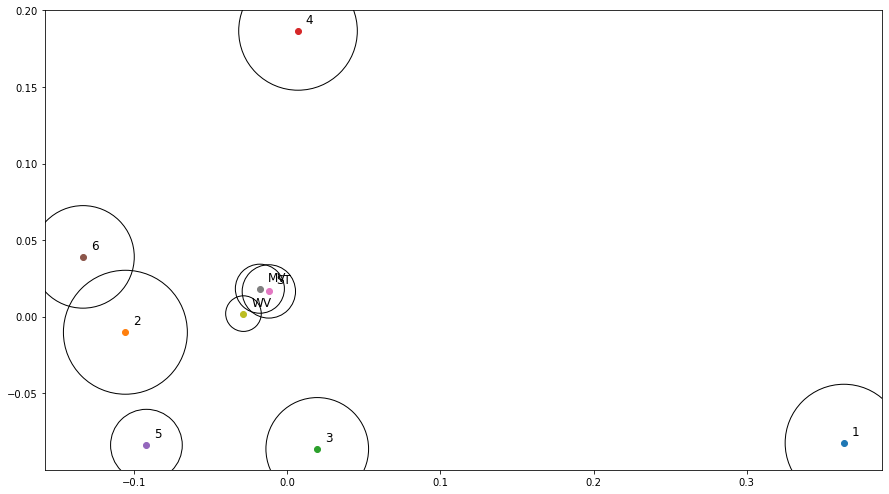

In [11]:
compute_and_plot_mds(diss, labels, 2)

## Removed annotations

In [12]:
import os
from skimage.io import imread
from matplotlib import pyplot as plt
%matplotlib inline

# Checking that the has_annotations table is correct:

datadir = 'e:/data/Gleason2019final'
all_images = os.listdir(os.path.join(datadir, 'train'))

Expert 1 / slide002_core009: map but has_annotations is False


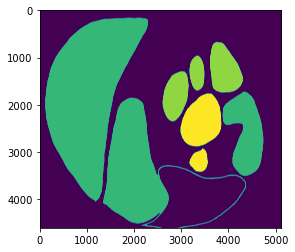

Expert 1 / slide002_core010: map but has_annotations is False


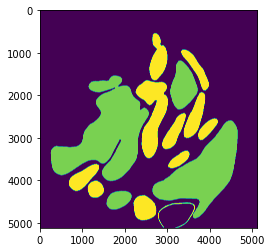

Expert 1 / slide003_core038: map but has_annotations is False


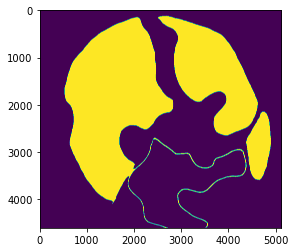

Expert 1 / slide007_core043: map but has_annotations is False


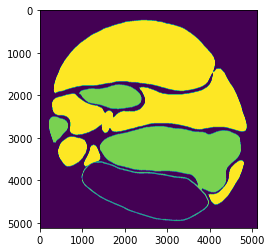

Expert 1 / slide007_core047: map but has_annotations is False


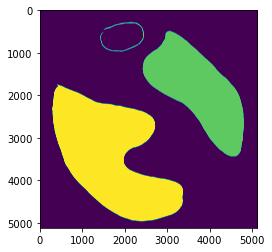

Expert 2 / slide001_core004: map but has_annotations is False


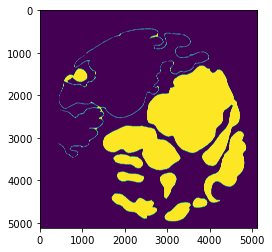

Expert 2 / slide001_core005: map but has_annotations is False


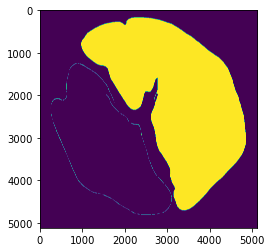

Expert 2 / slide001_core010: map but has_annotations is False


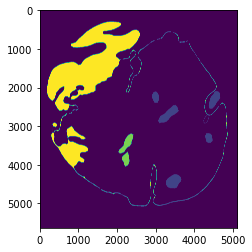

Expert 2 / slide001_core030: map but has_annotations is False


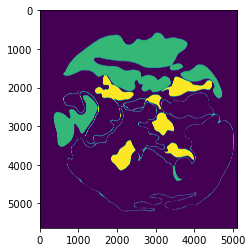

Expert 2 / slide001_core040: map but has_annotations is False


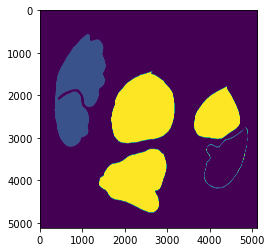

Expert 2 / slide001_core041: map but has_annotations is False


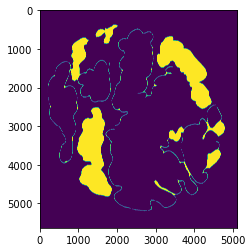

Expert 2 / slide001_core059: map but has_annotations is False


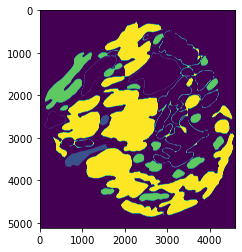

Expert 2 / slide001_core065: map but has_annotations is False


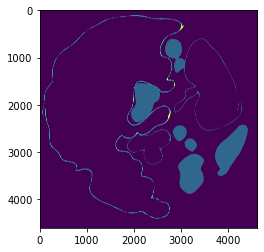

Expert 2 / slide001_core070: map but has_annotations is False


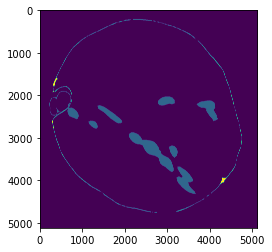

Expert 2 / slide001_core086: map but has_annotations is False


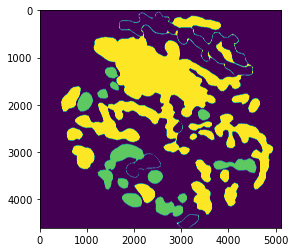

Expert 2 / slide001_core111: map but has_annotations is False


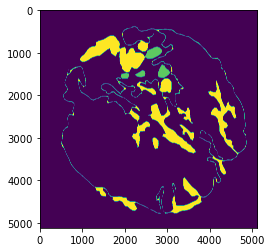

Expert 2 / slide001_core112: map but has_annotations is False


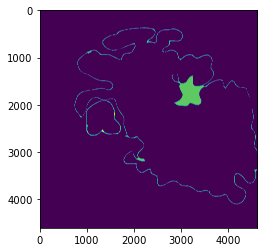

Expert 2 / slide001_core134: map but has_annotations is False


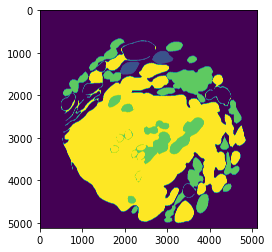

Expert 2 / slide001_core146: map but has_annotations is False


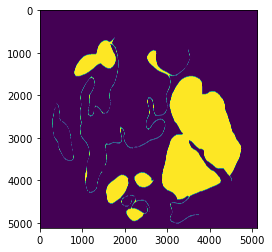

Expert 2 / slide001_core159: map but has_annotations is False


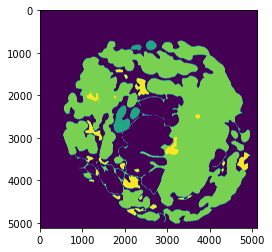

Expert 2 / slide001_core160: map but has_annotations is False


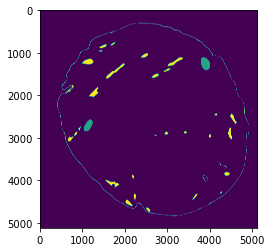

Expert 2 / slide002_core002: map but has_annotations is False


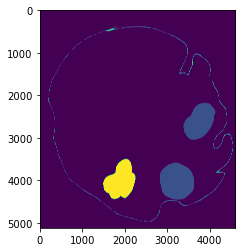

Expert 2 / slide002_core009: map but has_annotations is False


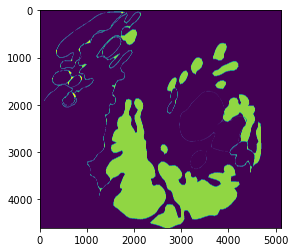

Expert 2 / slide002_core010: map but has_annotations is False


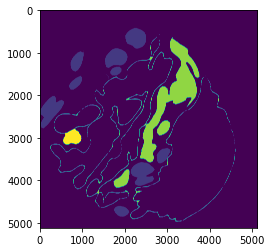

Expert 2 / slide002_core017: map but has_annotations is False


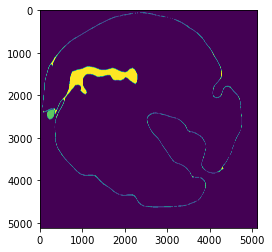

Expert 2 / slide002_core026: map but has_annotations is False


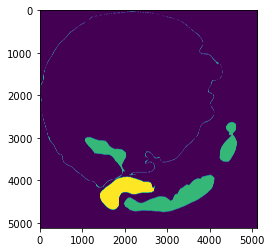

Expert 2 / slide002_core030: map but has_annotations is False


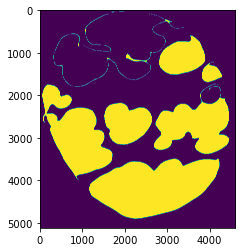

Expert 2 / slide002_core033: map but has_annotations is False


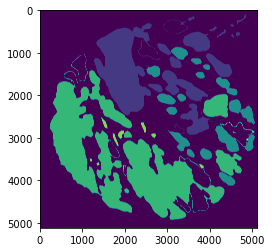

Expert 2 / slide002_core041: map but has_annotations is False


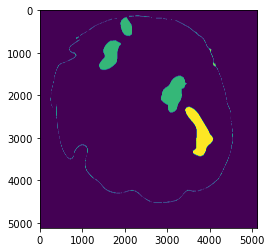

Expert 2 / slide002_core042: map but has_annotations is False


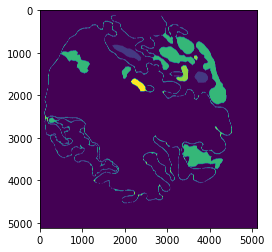

Expert 2 / slide002_core050: map but has_annotations is False


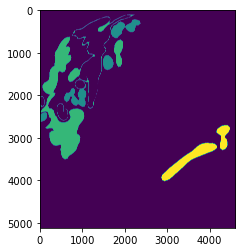

Expert 2 / slide002_core052: map but has_annotations is False


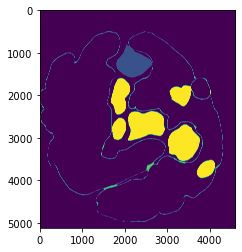

Expert 2 / slide002_core062: map but has_annotations is False


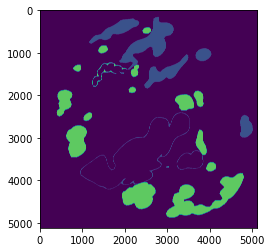

Expert 2 / slide002_core071: map but has_annotations is False


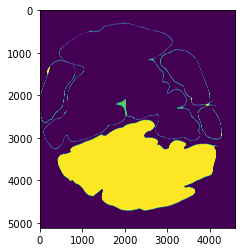

Expert 2 / slide002_core072: map but has_annotations is False


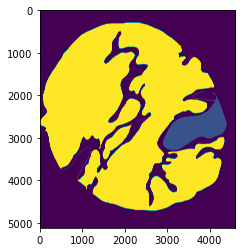

Expert 2 / slide002_core073: map but has_annotations is False


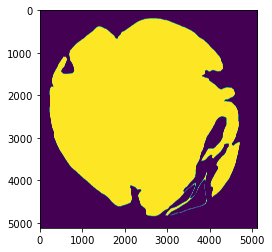

Expert 2 / slide002_core074: map but has_annotations is False


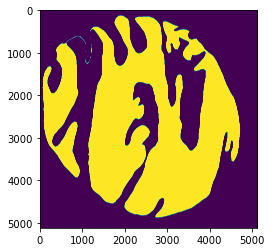

Expert 2 / slide002_core080: map but has_annotations is False


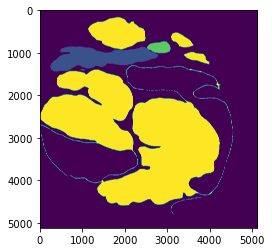

Expert 2 / slide002_core082: map but has_annotations is False


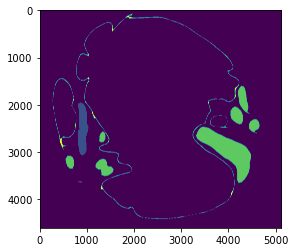

Expert 2 / slide002_core139: map but has_annotations is False


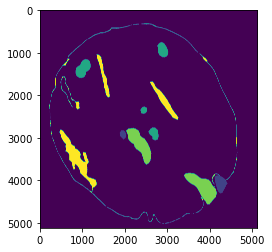

Expert 2 / slide002_core140: map but has_annotations is False


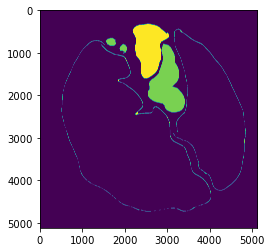

Expert 2 / slide002_core144: map but has_annotations is False


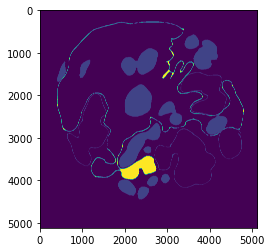

Expert 2 / slide003_core004: map but has_annotations is False


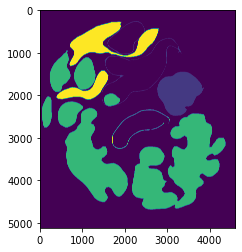

Expert 2 / slide003_core005: map but has_annotations is False


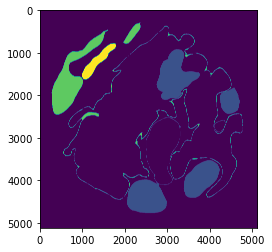

Expert 2 / slide003_core010: map but has_annotations is False


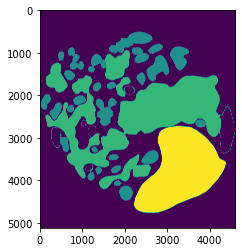

Expert 2 / slide003_core031: map but has_annotations is False


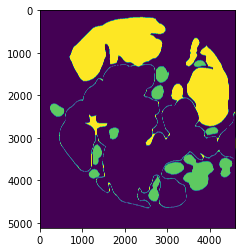

Expert 2 / slide003_core038: map but has_annotations is False


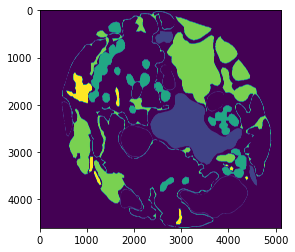

Expert 2 / slide003_core046: map but has_annotations is False


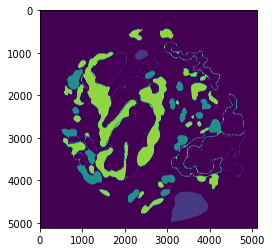

Expert 2 / slide003_core055: map but has_annotations is False


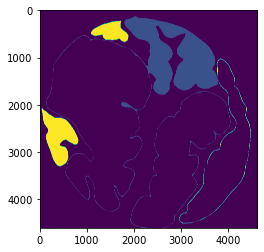

Expert 2 / slide003_core056: map but has_annotations is False


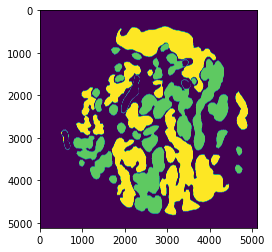

Expert 2 / slide003_core068: map but has_annotations is False


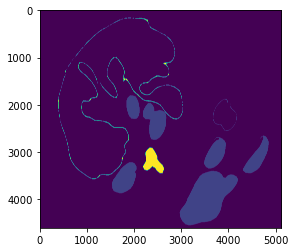

Expert 2 / slide003_core080: map but has_annotations is False


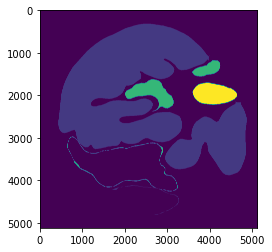

Expert 2 / slide003_core083: map but has_annotations is False


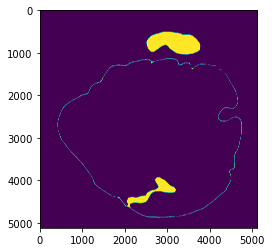

Expert 2 / slide003_core114: map but has_annotations is False


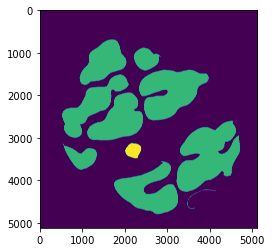

Expert 2 / slide003_core125: map but has_annotations is False


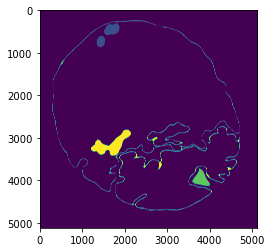

Expert 2 / slide005_core009: map but has_annotations is False


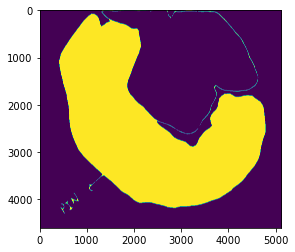

Expert 2 / slide005_core029: map but has_annotations is False


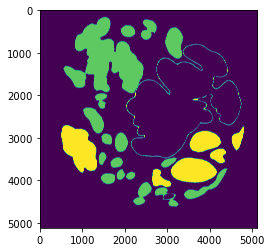

Expert 2 / slide005_core034: map but has_annotations is False


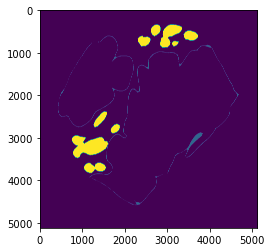

Expert 2 / slide005_core041: map but has_annotations is False


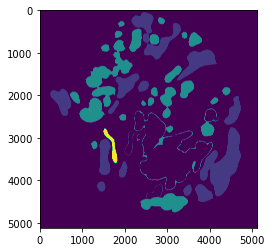

Expert 2 / slide005_core063: map but has_annotations is False


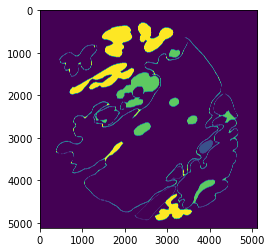

Expert 2 / slide005_core064: map but has_annotations is False


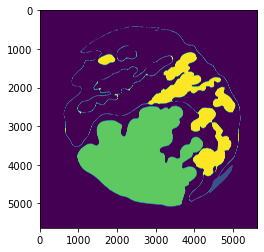

Expert 2 / slide005_core069: map but has_annotations is False


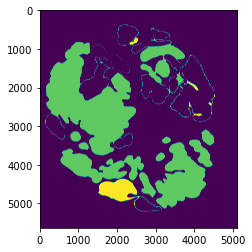

Expert 2 / slide005_core073: map but has_annotations is False


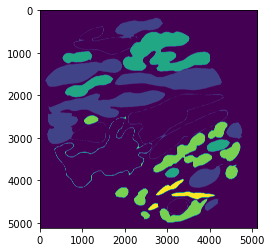

Expert 2 / slide005_core074: map but has_annotations is False


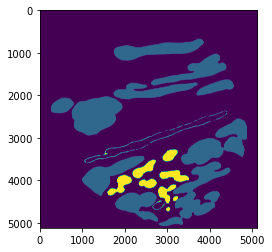

Expert 2 / slide005_core087: map but has_annotations is False


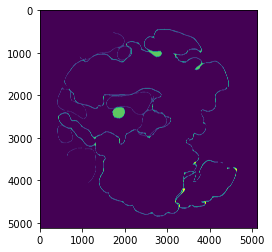

Expert 2 / slide005_core090: map but has_annotations is False


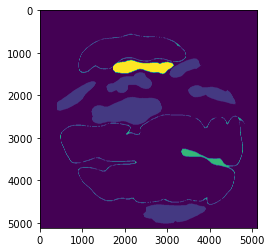

Expert 2 / slide005_core092: map but has_annotations is False


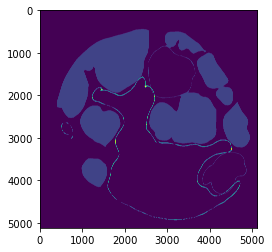

Expert 2 / slide005_core093: map but has_annotations is False


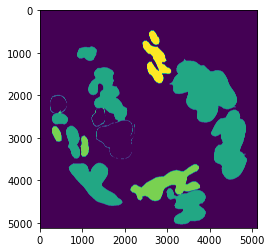

Expert 2 / slide005_core097: map but has_annotations is False


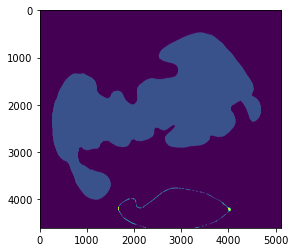

Expert 2 / slide005_core122: map but has_annotations is False


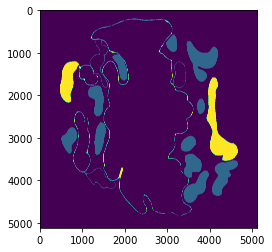

Expert 2 / slide005_core131: map but has_annotations is False


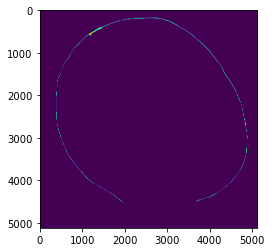

Expert 2 / slide005_core140: map but has_annotations is False


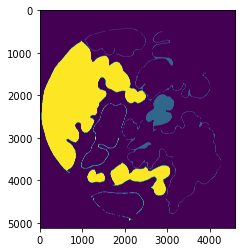

Expert 2 / slide005_core154: map but has_annotations is False


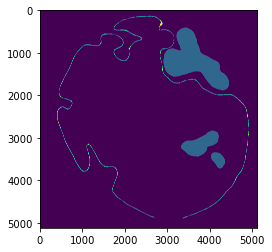

Expert 2 / slide006_core004: map but has_annotations is False


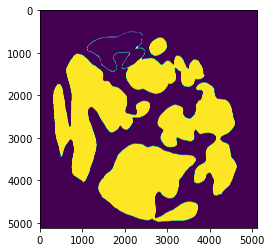

Expert 2 / slide006_core010: map but has_annotations is False


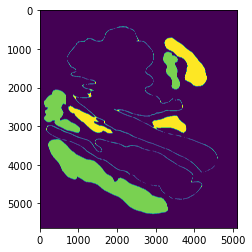

Expert 2 / slide006_core011: map but has_annotations is False


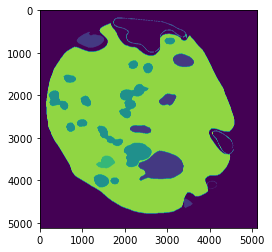

Expert 2 / slide006_core012: map but has_annotations is False


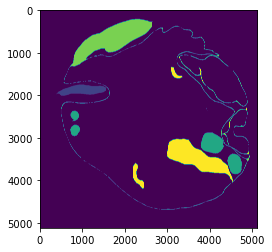

Expert 2 / slide006_core023: map but has_annotations is False


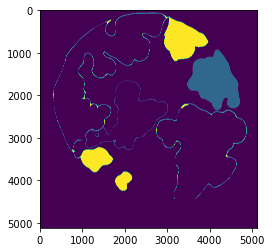

Expert 2 / slide006_core046: map but has_annotations is False


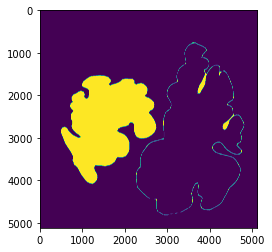

Expert 2 / slide006_core066: map but has_annotations is False


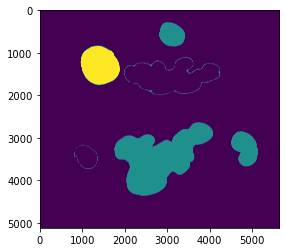

Expert 2 / slide006_core077: map but has_annotations is False


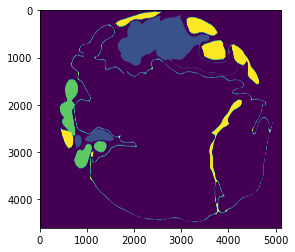

Expert 2 / slide006_core078: map but has_annotations is False


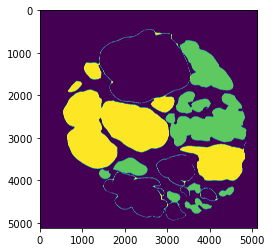

Expert 2 / slide006_core082: map but has_annotations is False


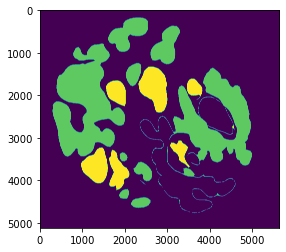

Expert 2 / slide006_core083: map but has_annotations is False


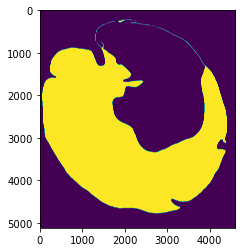

Expert 2 / slide006_core084: map but has_annotations is False


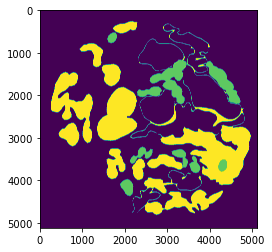

Expert 2 / slide006_core088: map but has_annotations is False


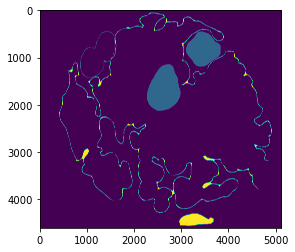

Expert 2 / slide006_core089: map but has_annotations is False


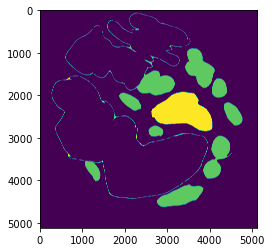

Expert 2 / slide006_core090: map but has_annotations is False


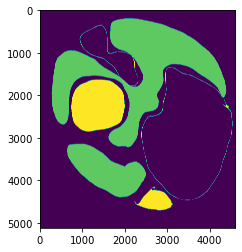

Expert 2 / slide006_core098: map but has_annotations is False


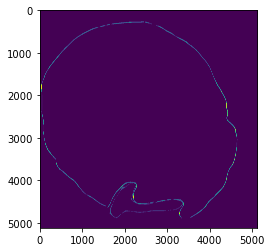

Expert 2 / slide006_core100: map but has_annotations is False


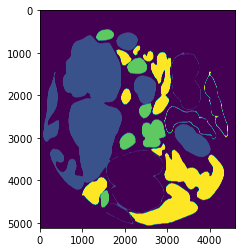

Expert 2 / slide006_core101: map but has_annotations is False


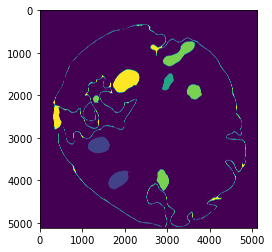

Expert 2 / slide006_core102: map but has_annotations is False


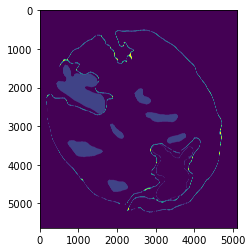

Expert 2 / slide006_core105: map but has_annotations is False


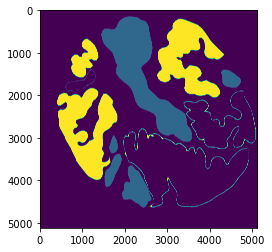

Expert 2 / slide006_core110: map but has_annotations is False


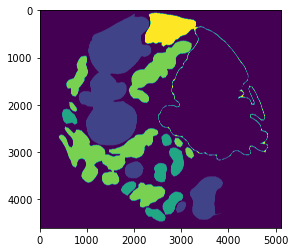

Expert 2 / slide006_core113: map but has_annotations is False


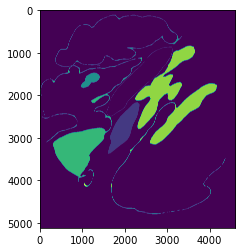

Expert 2 / slide006_core114: map but has_annotations is False


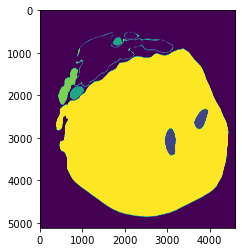

Expert 2 / slide006_core115: map but has_annotations is False


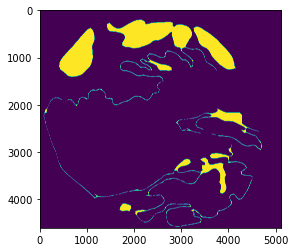

Expert 2 / slide006_core116: map but has_annotations is False


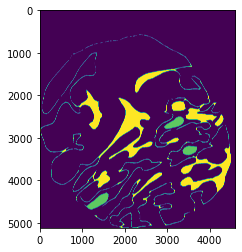

Expert 2 / slide006_core120: map but has_annotations is False


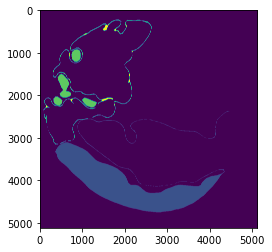

Expert 2 / slide006_core125: map but has_annotations is False


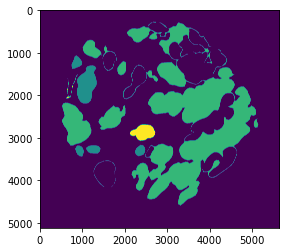

Expert 2 / slide006_core129: map but has_annotations is False


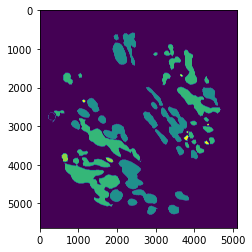

Expert 2 / slide006_core136: map but has_annotations is False


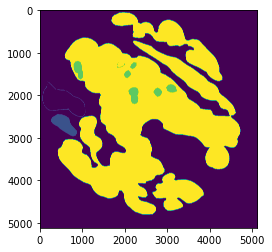

Expert 2 / slide006_core142: map but has_annotations is False


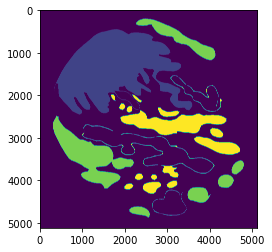

Expert 2 / slide006_core155: map but has_annotations is False


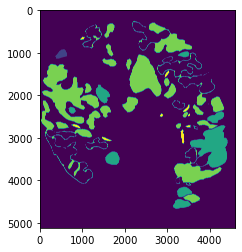

Expert 2 / slide007_core002: map but has_annotations is False


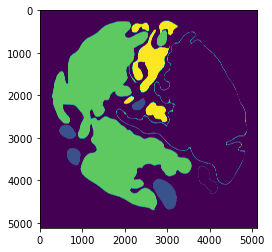

Expert 2 / slide007_core006: map but has_annotations is False


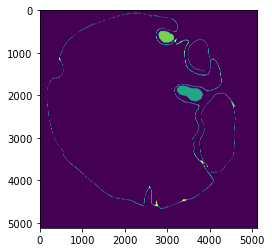

Expert 2 / slide007_core008: map but has_annotations is False


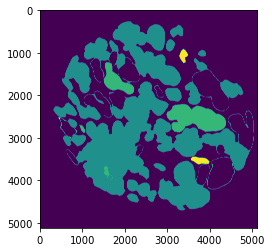

Expert 2 / slide007_core014: map but has_annotations is False


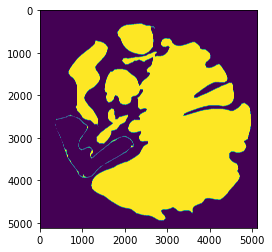

Expert 2 / slide007_core015: map but has_annotations is False


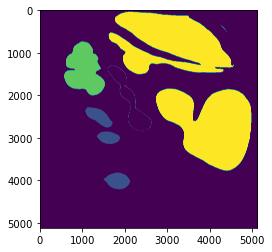

Expert 2 / slide007_core016: map but has_annotations is False


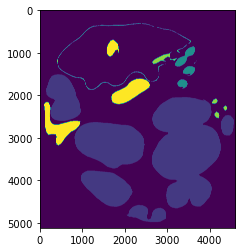

Expert 2 / slide007_core024: map but has_annotations is False


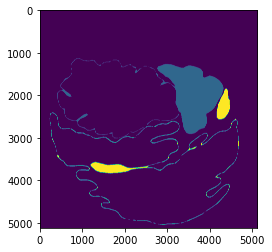

Expert 2 / slide007_core031: map but has_annotations is False


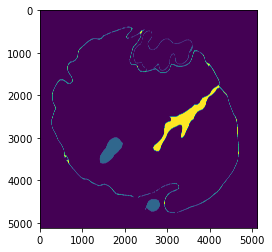

Expert 2 / slide007_core033: map but has_annotations is False


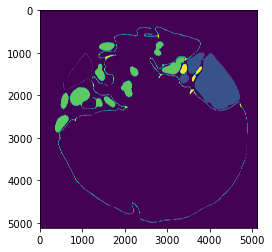

Expert 2 / slide007_core038: map but has_annotations is False


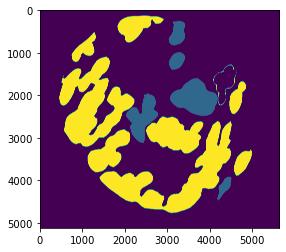

Expert 2 / slide007_core046: map but has_annotations is False


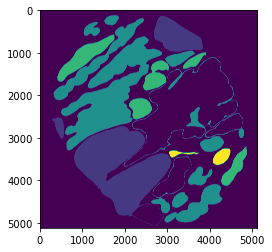

Expert 2 / slide007_core047: map but has_annotations is False


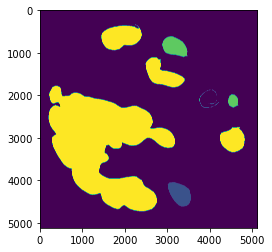

Expert 2 / slide007_core048: map but has_annotations is False


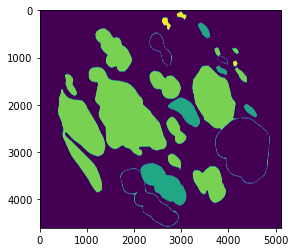

Expert 2 / slide007_core055: map but has_annotations is False


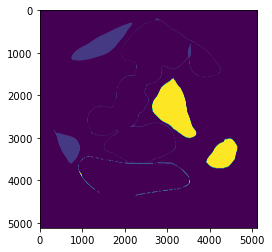

Expert 2 / slide007_core056: map but has_annotations is False


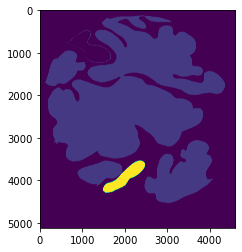

Expert 2 / slide007_core057: map but has_annotations is False


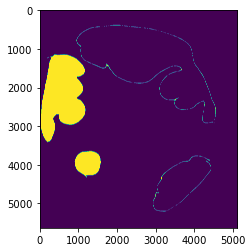

Expert 2 / slide007_core070: map but has_annotations is False


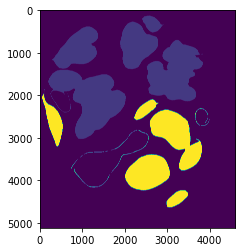

Expert 2 / slide007_core107: map but has_annotations is False


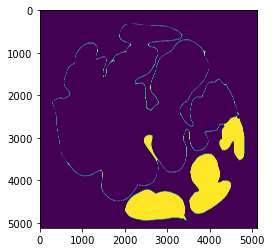

Expert 2 / slide007_core146: map but has_annotations is False


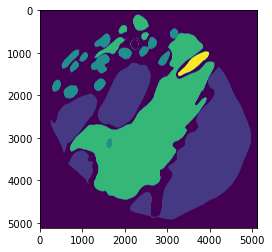

Expert 2 / slide007_core149: map but has_annotations is False


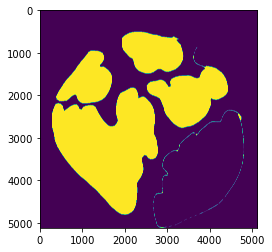

Expert 3 / slide001_core008: map but has_annotations is False


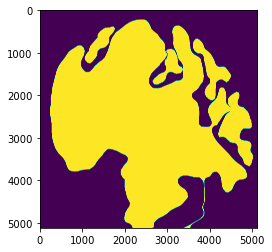

Expert 3 / slide001_core009: map but has_annotations is False


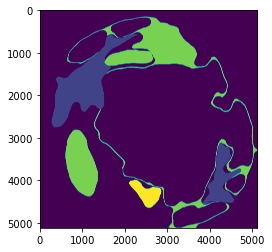

Expert 3 / slide001_core011: map but has_annotations is False


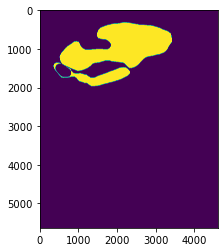

Expert 3 / slide001_core049: map but has_annotations is False


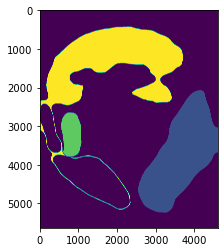

Expert 3 / slide001_core055: map but has_annotations is False


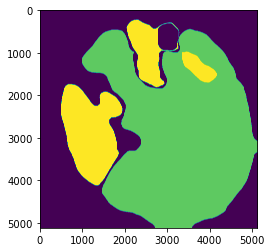

Expert 3 / slide001_core059: map but has_annotations is False


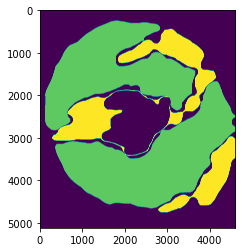

Expert 3 / slide001_core067: map but has_annotations is False


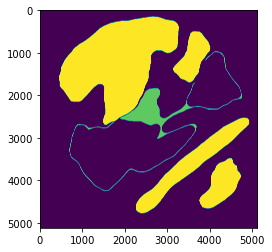

Expert 3 / slide001_core077: map but has_annotations is False


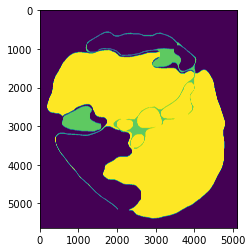

Expert 3 / slide001_core079: map but has_annotations is False


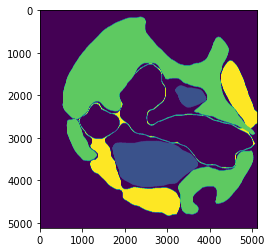

Expert 3 / slide001_core086: map but has_annotations is False


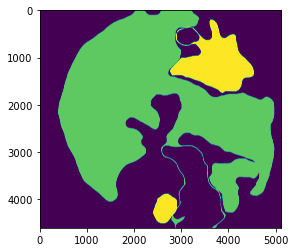

Expert 3 / slide001_core095: map but has_annotations is False


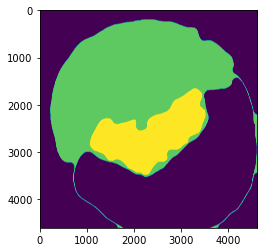

Expert 3 / slide001_core098: map but has_annotations is False


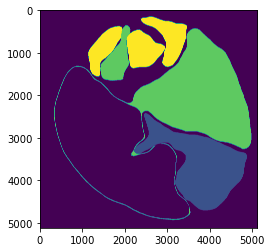

Expert 3 / slide001_core111: map but has_annotations is False


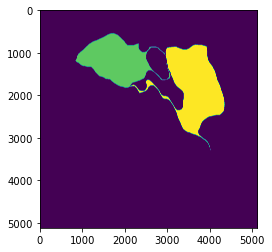

Expert 3 / slide002_core002: map but has_annotations is False


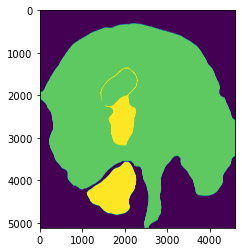

Expert 3 / slide002_core009: map but has_annotations is False


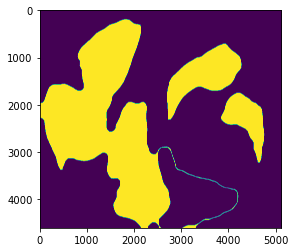

Expert 3 / slide002_core010: map but has_annotations is False


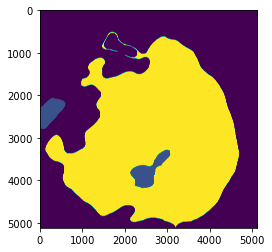

Expert 3 / slide002_core033: map but has_annotations is False


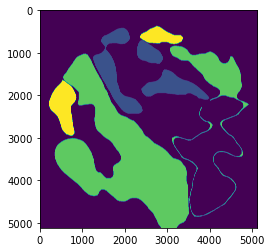

Expert 3 / slide002_core081: map but has_annotations is False


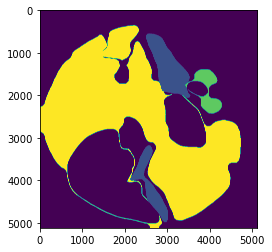

Expert 3 / slide003_core010: map but has_annotations is False


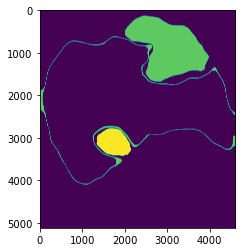

Expert 3 / slide003_core023: map but has_annotations is False


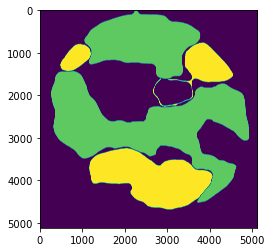

Expert 3 / slide003_core038: map but has_annotations is False


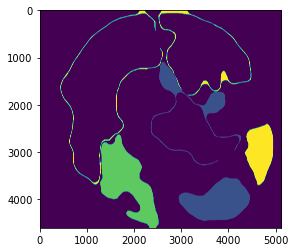

Expert 3 / slide003_core046: map but has_annotations is False


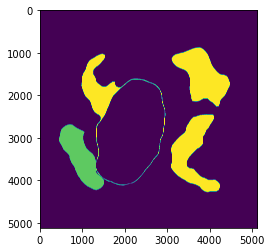

Expert 3 / slide003_core075: map but has_annotations is False


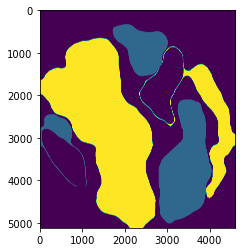

Expert 3 / slide003_core080: map but has_annotations is False


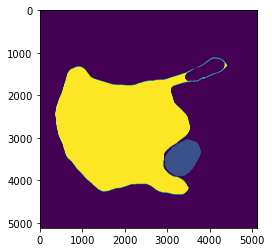

Expert 3 / slide003_core092: map but has_annotations is False


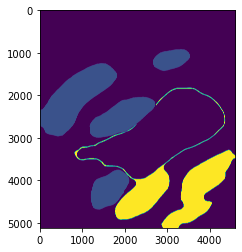

Expert 3 / slide003_core117: map but has_annotations is False


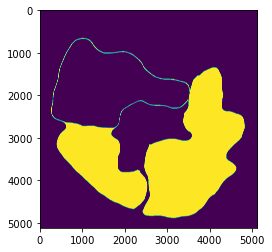

Expert 3 / slide003_core133: map but has_annotations is False


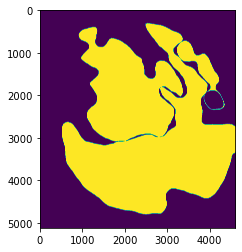

Expert 3 / slide005_core041: map but has_annotations is False


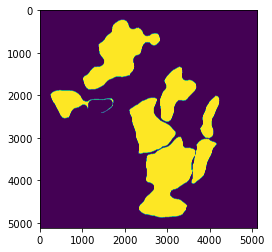

Expert 3 / slide005_core051: map but has_annotations is False


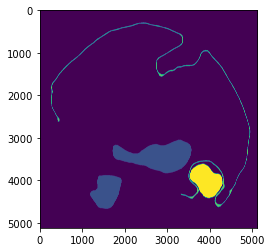

Expert 3 / slide005_core064: map but has_annotations is False


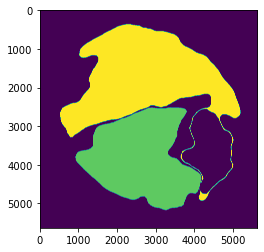

Expert 3 / slide005_core073: map but has_annotations is False


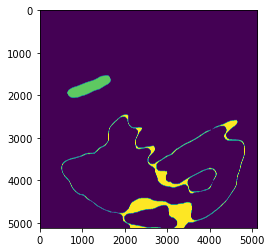

Expert 3 / slide005_core074: map but has_annotations is False


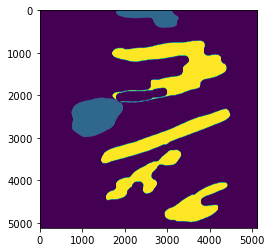

Expert 3 / slide005_core091: map but has_annotations is False


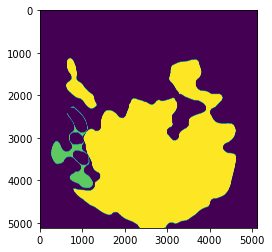

Expert 3 / slide005_core094: map but has_annotations is False


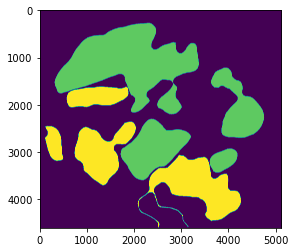

Expert 3 / slide005_core117: map but has_annotations is False


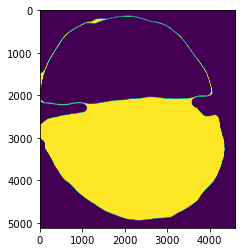

Expert 3 / slide005_core132: map but has_annotations is False


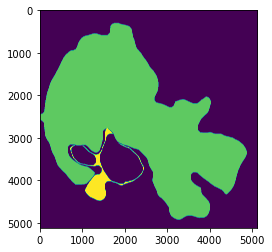

Expert 3 / slide005_core147: map but has_annotations is False


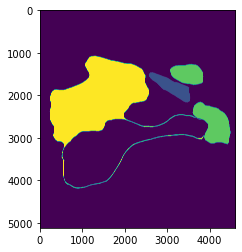

Expert 3 / slide006_core003: map but has_annotations is False


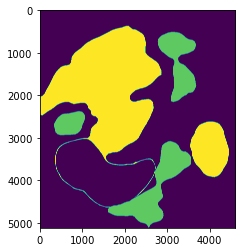

Expert 3 / slide006_core047: map but has_annotations is False


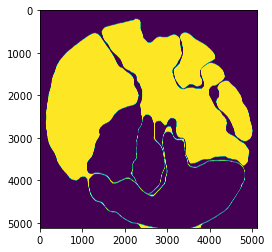

Expert 3 / slide006_core078: map but has_annotations is False


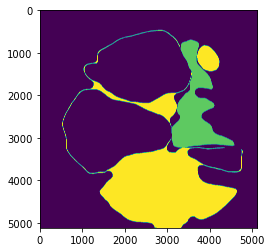

Expert 3 / slide006_core084: map but has_annotations is False


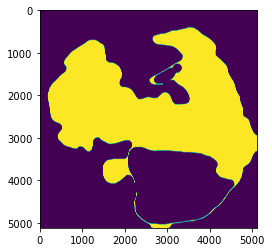

Expert 3 / slide006_core087: map but has_annotations is False


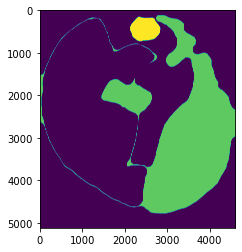

Expert 3 / slide006_core089: map but has_annotations is False


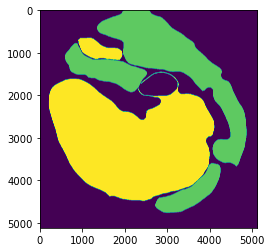

Expert 3 / slide006_core090: map but has_annotations is False


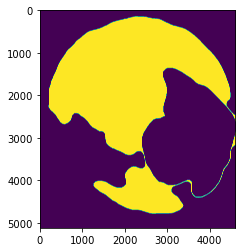

Expert 3 / slide006_core098: map but has_annotations is False


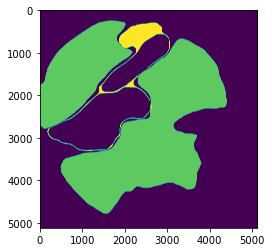

Expert 3 / slide006_core100: map but has_annotations is False


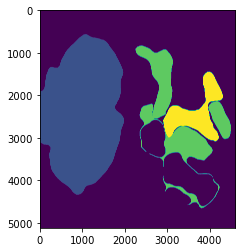

Expert 3 / slide006_core109: map but has_annotations is False


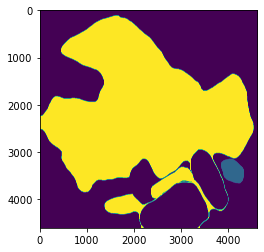

Expert 3 / slide006_core115: map but has_annotations is False


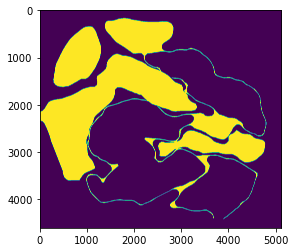

Expert 3 / slide006_core136: map but has_annotations is False


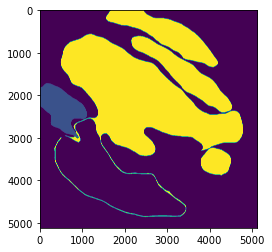

Expert 3 / slide007_core013: map but has_annotations is False


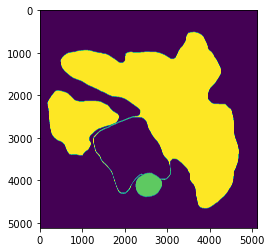

Expert 3 / slide007_core038: map but has_annotations is False


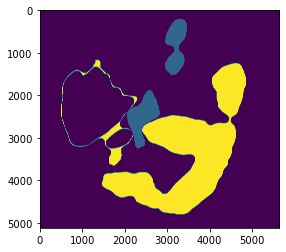

Expert 3 / slide007_core046: map but has_annotations is False


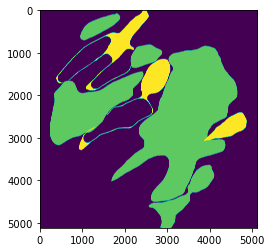

Expert 3 / slide007_core048: map but has_annotations is False


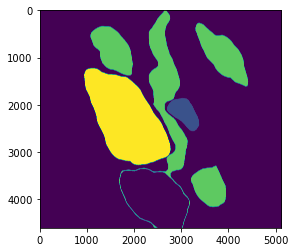

Expert 3 / slide007_core146: map but has_annotations is False


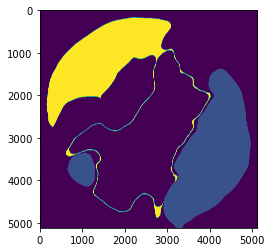

Expert 4 / slide002_core030: map but has_annotations is False


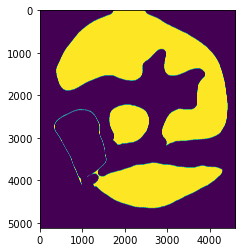

Expert 4 / slide002_core080: map but has_annotations is False


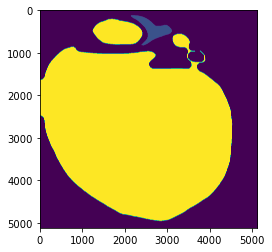

Expert 4 / slide005_core038: map but has_annotations is False


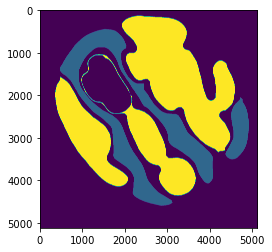

Expert 4 / slide006_core109: map but has_annotations is False


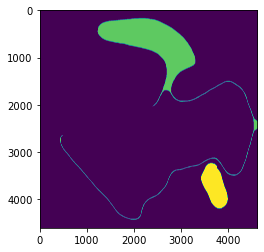

Expert 4 / slide007_core046: map but has_annotations is False


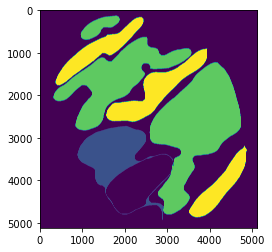

Expert 4 / slide007_core048: map but has_annotations is False


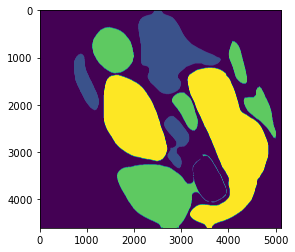

Expert 6 / slide006_core120: map but has_annotations is False


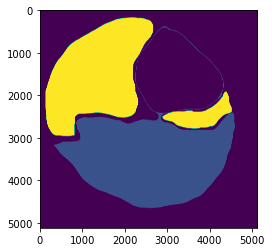

In [13]:
for i in range(1, 7):
    expert_dir = os.path.join(datadir, f'Maps{i}_T')
    maps = os.listdir(expert_dir)

    for idi, im in enumerate(all_images):
        f = im[:-4]
        if f'{f}_classimg_nonconvex.png' not in maps and has_annotations[idi, i-1]:
            print(f"Expert {i} / {f}: no map but has_annotations is True")
        if f'{f}_classimg_nonconvex.png' in maps and not has_annotations[idi, i-1]:
            print(f"Expert {i} / {f}: map but has_annotations is False")
            annotations = imread(os.path.join(expert_dir, f'{f}_classimg_nonconvex.png'))
            plt.figure()
            plt.imshow(annotations)
            plt.show()